In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import skimage as ski
import sklearn as skl

import fct

from scipy import misc
from sklearn import cluster

# Kmeans
from skimage.exposure import (equalize_hist, equalize_adapthist, 
                              rescale_intensity)
from skimage.morphology import dilation, disk
from skimage.filters.rank import median

# Hough ellipse
from skimage import data, color
from skimage.feature import canny, peak_local_max
from skimage.transform import hough_ellipse, hough_circle
from skimage.draw import ellipse_perimeter

In [2]:
def read_img(nb, eye, img_nb):
    folder = 'input/IR/'
    file = folder + nb + '/' + nb + '_' + eye + '/'
    file += 'Img_' + nb + '_' + eye + '_' + img_nb + '.bmp'
    img = misc.imread(file)

    return img

In [3]:
img1 = read_img('001', 'L', '1')
img2 = read_img('002', 'L', '2')

In [4]:
def kmeans(img):
    n_clusters = 10
    np.random.seed(0)

    X = img.reshape((-1, 1))  # We need an (n_sample, n_feature) array
    k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
    k_means.fit(X)
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_

    # create an array from labels and values
    img_compressed = np.choose(labels, values)
    img_compressed.shape = img.shape

    return img_compressed

In [54]:
img = img2
img_eq = fct.normalize(equalize_adapthist(img)).astype(np.uint8)

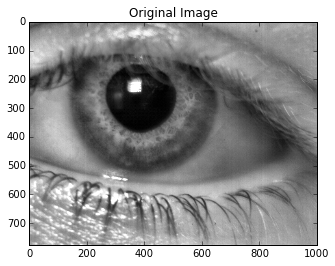

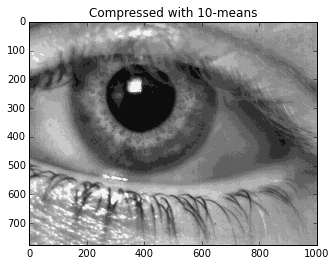

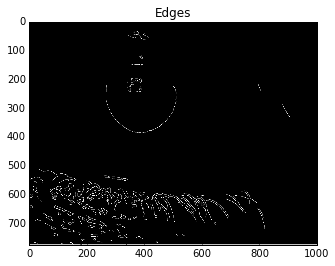

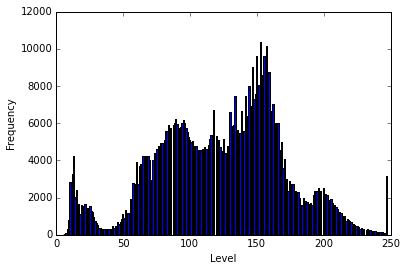

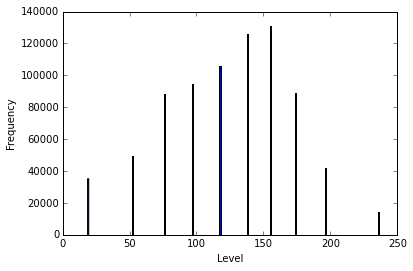

In [55]:
vmin = img.min()
vmax = img.max()

# img
plt.figure()
plt.title('Original Image')
plt.imshow(img_eq, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

# Kmeans
plt.figure()
plt.title('Compressed with 10-means')
img_compressed = kmeans(img_eq)
plt.imshow(img_compressed, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

# Edges
edges = canny(img)
plt.figure()
plt.title('Edges')
plt.imshow(edges)

# Histo
fct.freq(img)
fct.freq(img_compressed)

plt.show()

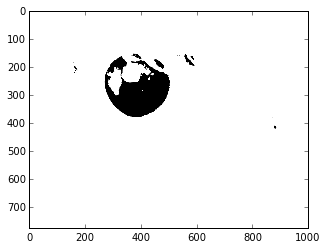

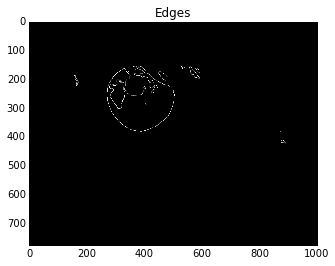

In [56]:
small_circle = dilation(255 - fct.threshold(img_compressed, 50), disk(2))
fct.display(small_circle)

# Edges
small_edges = canny(small_circle)
plt.figure()
plt.title('Edges')
plt.imshow(small_edges)

In [57]:
def circle_det(img, edges, begin=50, end=150, step=20):
    hough_rad = np.arange(begin, end, step)
    hough_res = hough_circle(edges, hough_rad, normalize=True)

    centers = []
    accums = []
    radii = []

    for radius, h in zip(hough_rad, hough_res):
        # For each radius, extract two circles
        num_peaks = 8
        peaks = peak_local_max(h, num_peaks=num_peaks)
        centers.extend(peaks)
        accums.extend(h[peaks[:, 0], peaks[:, 1]])
        radii.extend([radius] * num_peaks)

    fig = plt.figure()
    image = color.gray2rgb(img)
    for idx in np.argsort(accums)[::-1][:5]:
        center_x, center_y = centers[idx]
        radius = radii[idx]
        circle = plt.Circle((center_y, center_x), radius, fill=False, color='r')
        fig.gca().add_artist(circle)
    plt.imshow(image)
    
    return hough_res

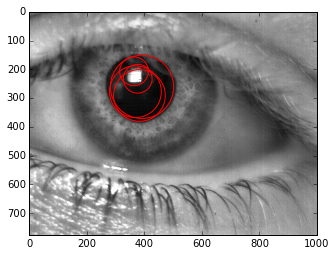

In [58]:
hough_res = circle_det(img_eq, small_edges, step=20)

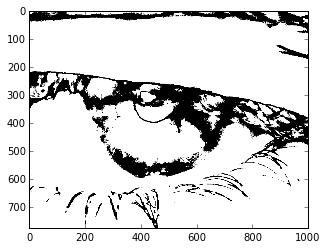

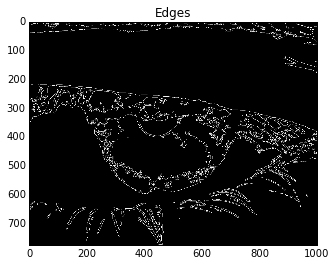

In [52]:
big_circle = 255 - fct.threshold(img_compressed, 100, 50)
fct.display(big_circle)

# Edges
big_edges = canny(big_circle)
plt.figure()
plt.title('Edges')
plt.imshow(big_edges)

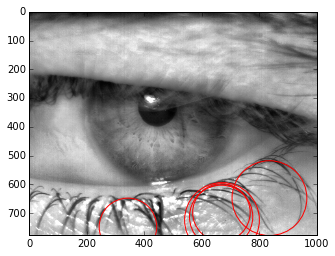

In [53]:
hough_res = circle_det(img_eq, edges, begin=100, end=1000, step=10)